In [16]:
import uuid
import os
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import Column, Integer, String, DateTime, Text, ForeignKey
from sqlalchemy.orm import declarative_base
from datetime import datetime
from sqlalchemy.orm import relationship, backref
from sqlalchemy.orm import sessionmaker
import sqlalchemy
from pgvector.sqlalchemy import Vector
from sqlalchemy.dialects.postgresql import JSON, UUID

import os
import matplotlib.pyplot as plt
import tempfile
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision
from torchvision.utils import Image
from tqdm import tqdm
import natsort



In [13]:
url = URL.create(
    drivername="postgresql",
    username="postgres",
    password="postgres",
    host="localhost",
    port=5432,
    database="imagesv"
)

engine = create_engine(url)
connection = engine.connect()

Session = sessionmaker(bind=engine)
session = Session()

statement = sqlalchemy.text("CREATE EXTENSION IF NOT EXISTS vector")
session.execute(statement)
session.commit()

['Expressionism', 'Realism', 'Art_Nouveau', 'Symbolism', 'Japanese_Art']


In [14]:
Base = declarative_base()

class BaseModel(Base):
    __abstract__ = True
    uuid = sqlalchemy.Column(UUID(as_uuid=True), primary_key=True, default=uuid.uuid4)

class FeatureStore(BaseModel):
    __tablename__ = "images_vectors"

    features: Vector = sqlalchemy.Column(Vector(None))
    image_path =  sqlalchemy.Column(sqlalchemy.String, nullable=True)
    cmetadata = sqlalchemy.Column(JSON, nullable=True)

class QueryResult:
    FeatureStore: FeatureStore
    distance: float

# Base.metadata.create_all(engine)

[('/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism',
  'Expressionism',
  '/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185506.jpg'),
 ('/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism',
  'Expressionism',
  '/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189761.jpg'),
 ('/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism',
  'Expressionism',
  '/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821613.jpg'),
 ('/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism',
  'Expressionism',
  '/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189698.jpg'),
 ('/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism',
  'Expressionism',
  '/home/jaimec/Documents/Torch/learn_pytorch/images

In [4]:
class MyImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        return super(MyImageFolder, self).__getitem__(index), self.imgs[index]

class ImageDataSet(Dataset):

    def __init__(self, root='train', image_loader=None, transform=None):
        self.root = root
        self.image_files = [os.listdir(os.path.join(self.root, 'folder_{}'.format(i)) for i in range(1, 9)]
        self.loader = image_loader
        self.transform = transform
    def __len__(self):
        # Here, we need to return the number of samples in this dataset.
        return sum([len(folder) for folder in self.image_files])

    def __getitem__(self, index):
        images = [self.loader(os.path.join(root, 'folder_{}'.format(i), self.image_files[i][index])) for i in range(1, 9)]
        if self.transform is not None:
            images = [self.transform(img) for img in images]
        return images


In [5]:
def collate_fn(batch):
    images = []
    file_names = []
    for img, file_name in batch:
        images.append(img)
        file_names.append(file_name)
    return images, file_names

In [6]:
# load images
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# dataset = torchvision.datasets.ImageFolder(root='/home/jaimec/Documents/Torch/learn_pytorch/images/TDA', transform=transform)
dataset = MyImageFolder(root='/home/jaimec/Documents/Torch/learn_pytorch/images/arte',  transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100)

In [7]:
# load pretrained model
model = torchvision.models.resnet18(weights='DEFAULT')
model.fc = torch.nn.Identity()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def generate_embeddings(inputs):
    return model(inputs).detach().numpy()

In [9]:
paths = None
for data in tqdm(dataloader):
    (images, labels), (path,_) = data
    paths = path
    embeddings = generate_embeddings(images)

  0%|          | 0/148 [00:00<?, ?it/s]

----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188098.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188099.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188100.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188101.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188102.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188103.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188104.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188105.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188106.jpg
----9------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/1

  1%|          | 1/148 [00:17<41:59, 17.14s/it]

----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188238.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188239.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188240.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188241.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188244.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188245.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188246.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188252.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/188253.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouve

  1%|▏         | 2/148 [01:44<2:22:18, 58.48s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203601.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203602.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203603.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203604.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203605.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203606.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203607.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203608.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203609.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

  2%|▏         | 3/148 [02:39<2:17:26, 56.87s/it]

----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203726.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203727.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203728.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203729.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203730.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203731.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203732.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203733.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/203734.jpg
----9------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/2

  3%|▎         | 4/148 [03:34<2:14:43, 56.14s/it]

----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245435.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245436.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245437.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245438.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245439.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245440.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245441.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245442.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245443.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

  3%|▎         | 5/148 [03:55<1:43:46, 43.54s/it]

----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245682.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245683.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245684.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245685.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245686.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245687.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245688.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245689.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/245690.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_

  4%|▍         | 6/148 [04:18<1:25:57, 36.32s/it]

----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252286.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252287.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252288.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252289.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252290.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252291.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252292.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252293.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252294.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_

  5%|▍         | 7/148 [04:30<1:07:06, 28.56s/it]

----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252349.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252350.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252351.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252352.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252353.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252354.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252355.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252356.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252357.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

  5%|▌         | 8/148 [04:47<57:48, 24.77s/it]  

----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252501.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252502.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252503.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252504.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252505.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252506.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252507.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252508.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252509.jpg
----9------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/2

  6%|▌         | 9/148 [05:00<48:52, 21.10s/it]

----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252582.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252583.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252584.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252585.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252586.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252587.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252588.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252589.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252590.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

  7%|▋         | 10/148 [05:15<44:03, 19.16s/it]

----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252698.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252699.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252700.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252701.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252702.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252703.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252704.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252705.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252706.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouve

  7%|▋         | 11/148 [05:29<40:38, 17.80s/it]

----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252805.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252806.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252807.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252808.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252809.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252810.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252811.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252812.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/252813.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/

  8%|▊         | 12/148 [06:33<1:12:02, 31.78s/it]

----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255293.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255294.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255295.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255296.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255297.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255298.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255299.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255300.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255301.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouve

  9%|▉         | 13/148 [08:02<1:50:27, 49.09s/it]

----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255383.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255384.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255385.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255386.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255387.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255388.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255389.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255391.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/255392.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

  9%|▉         | 14/148 [08:27<1:33:06, 41.69s/it]

----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256696.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256697.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256698.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256699.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256700.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256701.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256702.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256703.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/256704.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau

 10%|█         | 15/148 [08:41<1:14:28, 33.60s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262860.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262861.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262862.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262863.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262864.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262865.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262866.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262867.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262868.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_No

 11%|█         | 16/148 [08:59<1:03:27, 28.85s/it]

----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262921.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262922.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262923.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262924.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262925.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262926.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262927.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262928.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/262929.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 11%|█▏        | 17/148 [09:17<55:38, 25.49s/it]  

----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281710.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281711.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281712.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281713.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281714.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281715.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281716.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281717.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281718.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/

 12%|█▏        | 18/148 [09:30<47:26, 21.90s/it]

----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281766.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281767.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281768.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281769.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281770.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281771.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281772.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281773.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/281774.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 13%|█▎        | 19/148 [09:47<43:23, 20.18s/it]

----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311024.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311025.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311026.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311027.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311028.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311029.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311030.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311031.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311032.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouv

 14%|█▎        | 20/148 [10:00<38:56, 18.25s/it]

----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311162.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311163.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311164.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311165.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311166.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311167.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311168.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311169.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/311170.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 14%|█▍        | 21/148 [10:15<36:20, 17.17s/it]

----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323203.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323204.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323205.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323206.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323207.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323208.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323209.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323210.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/323211.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 15%|█▍        | 22/148 [10:28<33:07, 15.78s/it]

----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359152.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359153.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359154.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359155.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359156.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359157.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359159.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359160.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/359161.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 16%|█▌        | 23/148 [10:43<32:45, 15.72s/it]

----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361298.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361299.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361300.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361302.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361303.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361305.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361306.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361307.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361308.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau

 16%|█▌        | 24/148 [10:57<31:20, 15.17s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361365.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361366.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361367.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361368.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361369.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361370.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361371.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361372.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361388.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 17%|█▋        | 25/148 [11:11<30:30, 14.89s/it]

----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361602.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361603.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361604.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361605.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361606.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361607.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361608.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361609.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/361610.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art

 18%|█▊        | 26/148 [11:24<29:13, 14.37s/it]

----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377818.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377819.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377820.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377821.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377822.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377823.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377824.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377840.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/377841.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouv

 18%|█▊        | 27/148 [11:38<28:42, 14.23s/it]

----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841123.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841126.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841127.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841128.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841129.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841130.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841131.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559841132.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/A

 19%|█▉        | 28/148 [11:58<31:36, 15.81s/it]

----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850604.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850605.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850606.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850607.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850609.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850610.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850611.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559850612.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/A

 20%|█▉        | 29/148 [12:26<38:57, 19.64s/it]

----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855120.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855121.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855122.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855123.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855124.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855125.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855126.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559855127.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/A

 20%|██        | 30/148 [12:53<42:45, 21.74s/it]

----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867488.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867489.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867490.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867491.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867492.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867493.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867494.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_Nouveau/9223372032559867495.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Art_Nouveau/Art_N

 21%|██        | 31/148 [13:08<38:19, 19.65s/it]

----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185388.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185389.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185390.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185391.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185393.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185394.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185395.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185396.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185397.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch

 22%|██▏       | 32/148 [13:22<34:47, 17.99s/it]

----48------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185440.jpg
----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185441.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185442.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185443.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185444.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185445.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185446.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185447.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/185448.jpg
----57------/home/jaimec/Documents/Torch/learn

 22%|██▏       | 33/148 [13:36<32:11, 16.79s/it]

----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189524.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189525.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189527.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189528.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189529.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189530.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189532.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189533.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189534.jpg
----99------/home/jaimec/Documents/Torch/learn

 23%|██▎       | 34/148 [13:50<30:15, 15.93s/it]

----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189591.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189592.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189593.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189594.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189595.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189596.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189597.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189598.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189599.jpg
----58------/home/jaimec/Documents/Torch/learn

 24%|██▎       | 35/148 [14:04<28:56, 15.37s/it]

----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189733.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189734.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189735.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189736.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189738.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189739.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189741.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189742.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/189743.jpg
----90------/home/jaimec/Documents/Torch/learn

 24%|██▍       | 36/148 [14:18<27:50, 14.91s/it]

----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231905.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231906.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231907.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231908.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231909.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231910.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231911.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231912.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231913.jpg
----78------/home/jaimec/Documents/Torch/learn

 25%|██▌       | 37/148 [14:31<26:34, 14.36s/it]

----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232017.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232018.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232019.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232020.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232021.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232022.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232023.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232024.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232025.jpg
----90------/home/jaimec/Documents/Torch/learn

 26%|██▌       | 38/148 [14:43<25:22, 13.84s/it]

----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232105.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232106.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232107.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232108.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232109.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232110.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232111.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232112.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/232113.jpg
----75------/home/jaimec/Documents/Torch/learn

 26%|██▋       | 39/148 [14:58<25:30, 14.04s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235869.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235870.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235871.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235873.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235874.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235875.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235876.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235877.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235878.jpg
----91------/home/jaimec/Documents/Torch/learn

 27%|██▋       | 40/148 [15:15<26:37, 14.79s/it]

----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235988.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235989.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235990.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235991.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235992.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235993.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235995.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235996.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/235997.jpg
----67------/home/jaimec/Documents/Torch/learn

 28%|██▊       | 41/148 [15:36<29:53, 16.76s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251949.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251950.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251951.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251952.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251953.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251954.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251955.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251956.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/251957.jpg
----2------/home/jaimec/Documents/Torch/learn_py

 28%|██▊       | 42/148 [15:59<32:45, 18.54s/it]

----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252080.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252081.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252082.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252083.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252084.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252085.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252086.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252087.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252088.jpg
----78------/home/jaimec/Documents/Torch/learn

 29%|██▉       | 43/148 [16:16<32:01, 18.30s/it]

----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252180.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252181.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252182.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252183.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252184.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252185.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252186.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252187.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252188.jpg
----76------/home/jaimec/Documents/Torch/learn

 30%|██▉       | 44/148 [16:36<32:15, 18.61s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252275.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252276.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252277.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252278.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252279.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/252280.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/268604.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/268605.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/268606.jpg
----64------/home/jaimec/Documents/Torch/learn

 30%|███       | 45/148 [16:47<28:06, 16.37s/it]

----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269786.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269787.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269788.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269791.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269793.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269794.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269795.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269796.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/269797.jpg
----85------/home/jaimec/Documents/Torch/learn

 31%|███       | 46/148 [17:01<26:48, 15.77s/it]

----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/279736.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280733.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280734.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280735.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280736.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280737.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280738.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280741.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/280742.jpg
----1------/home/jaimec/Documents/Torch/learn_p

 32%|███▏      | 47/148 [17:24<30:10, 17.93s/it]

----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295104.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295106.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295107.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295108.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295109.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295110.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295111.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295112.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295115.jpg
----95------/home/jaimec/Documents/Torch/learn

 32%|███▏      | 48/148 [17:53<35:14, 21.15s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295213.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/295214.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298769.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298770.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298771.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298772.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298773.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298774.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/298775.jpg
----64------/home/jaimec/Documents/Torch/learn

 33%|███▎      | 49/148 [18:07<31:16, 18.95s/it]

----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339582.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339583.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339584.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339585.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339586.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339587.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339588.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339589.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/339590.jpg
----9------/home/jaimec/Documents/Torch/learn_pytorch/i

 34%|███▍      | 50/148 [18:16<26:18, 16.11s/it]

----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346734.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346889.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346890.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346891.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346892.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346893.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346894.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346895.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/346896.jpg
----71------/home/jaimec/Documents/Torch/learn

 34%|███▍      | 51/148 [18:29<24:43, 15.29s/it]

----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811527.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811528.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811529.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811530.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811531.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811532.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811533.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559811534.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/

 35%|███▌      | 52/148 [19:25<43:39, 27.28s/it]

----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821485.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821486.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821487.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821488.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821489.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821490.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821491.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821492.jpg
----80------/home/jaimec/Documents/Torch/learn_p

 36%|███▌      | 53/148 [19:51<42:36, 26.91s/it]

----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821639.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821640.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821641.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821642.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821643.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821645.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821646.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559821647.jpg
----2------/home/jaimec/Documents/Torch/learn_pyto

 36%|███▋      | 54/148 [20:01<34:15, 21.86s/it]

----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835264.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835265.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835266.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835267.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835268.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835269.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835270.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559835271.jpg
----58------/home/jaimec/Documents/Torch/learn_p

 37%|███▋      | 55/148 [20:11<28:20, 18.29s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559855445.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559855446.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559855447.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559855448.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559858057.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860847.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860848.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860849.jpg
----1------/home/jaimec/Documents/Torch/learn_pyt

 38%|███▊      | 56/148 [20:15<21:42, 14.16s/it]

----48------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860897.jpg
----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860898.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860899.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860900.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860901.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860902.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860903.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/9223372032559860904.jpg
----56------/home/jaimec/Documents/Torch/learn_p

 39%|███▊      | 57/148 [20:23<18:24, 12.14s/it]

----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193005.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193006.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193007.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193008.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193009.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193010.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193011.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193012.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/193013.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 39%|███▉      | 58/148 [20:33<17:17, 11.52s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222197.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222198.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222199.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222200.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222201.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222202.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222203.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222204.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/222205.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/

 40%|███▉      | 59/148 [20:40<15:13, 10.27s/it]

----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223558.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223559.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223560.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223561.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223562.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223563.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223564.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223565.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223566.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 41%|████      | 60/148 [20:49<14:17,  9.74s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223628.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223629.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223630.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223631.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223632.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223633.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223634.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223635.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/223636.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 41%|████      | 61/148 [20:54<12:11,  8.41s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233146.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233147.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233148.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233149.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233150.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233151.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233152.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233153.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233154.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 42%|████▏     | 62/148 [21:04<12:38,  8.82s/it]

----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233268.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233269.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233270.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233271.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233272.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233273.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233274.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233275.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233276.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 43%|████▎     | 63/148 [21:13<12:34,  8.87s/it]

----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233602.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233603.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233604.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233605.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233607.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233608.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233609.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233610.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233611.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 43%|████▎     | 64/148 [21:23<12:49,  9.16s/it]

----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233692.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233693.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233694.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233695.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233696.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233697.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233698.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233699.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/233700.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 44%|████▍     | 65/148 [21:30<11:57,  8.65s/it]

----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240343.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240344.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240345.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240346.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240347.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240348.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240349.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240350.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/240351.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/J

 45%|████▍     | 66/148 [21:36<10:53,  7.97s/it]

----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242423.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242424.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242425.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242426.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242427.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242428.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242429.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242430.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/242431.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 45%|████▌     | 67/148 [21:41<09:27,  7.00s/it]

----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297397.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297398.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297399.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297400.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297401.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297402.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297403.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297404.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/297405.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 46%|████▌     | 68/148 [21:46<08:24,  6.31s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310769.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310770.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310771.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310772.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310773.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310774.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310775.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310776.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/310777.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 47%|████▋     | 69/148 [21:51<07:39,  5.82s/it]

----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/314750.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315658.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315659.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315660.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315661.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315662.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315663.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315664.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/315665.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 47%|████▋     | 70/148 [21:55<07:11,  5.54s/it]

----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317571.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317572.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317573.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317574.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317575.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317576.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317577.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317578.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317579.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 48%|████▊     | 71/148 [22:01<07:05,  5.53s/it]

----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317656.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317657.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317658.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317659.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317660.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317661.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317662.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317663.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/317664.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 49%|████▊     | 72/148 [22:06<06:55,  5.46s/it]

----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/318453.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/318454.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/318455.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/318456.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/329621.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/329622.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/329623.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/329624.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/329625.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/J

 49%|████▉     | 73/148 [22:13<07:18,  5.85s/it]

----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333103.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333104.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333105.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333106.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333107.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333108.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333109.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333110.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/333111.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 50%|█████     | 74/148 [22:24<09:05,  7.38s/it]

----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821023.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821024.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821025.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821026.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821027.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821028.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821029.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559821030.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/art

 51%|█████     | 75/148 [22:32<09:14,  7.60s/it]

----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823731.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823732.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823733.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823734.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823735.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823736.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823737.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559823738.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 51%|█████▏    | 76/148 [22:39<08:47,  7.33s/it]

----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850774.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850775.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850776.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850777.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850778.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850779.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850780.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850781.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 52%|█████▏    | 77/148 [22:48<09:15,  7.82s/it]

----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850863.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850864.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850865.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850866.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850867.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850868.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850869.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559850870.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 53%|█████▎    | 78/148 [22:54<08:28,  7.26s/it]

----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854123.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854124.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854125.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854126.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854127.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854128.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854129.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Japanese_Art/Japanese_Art/9223372032559854130.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 53%|█████▎    | 79/148 [23:00<08:06,  7.05s/it]

----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186908.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186909.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186910.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186911.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186912.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186913.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186914.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186915.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186916.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/186917.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/image

 54%|█████▍    | 80/148 [23:05<07:20,  6.48s/it]

----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189978.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189979.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189980.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189981.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189982.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189983.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189984.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189985.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189986.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/189987.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/image

 55%|█████▍    | 81/148 [23:12<07:16,  6.51s/it]

----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191708.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191709.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191710.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191711.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191712.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191713.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191714.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191715.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191716.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191717.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/image

 55%|█████▌    | 82/148 [23:18<06:54,  6.27s/it]

----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191831.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191832.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191833.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191834.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191835.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191836.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191837.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191838.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191839.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191840.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/image

 56%|█████▌    | 83/148 [23:23<06:25,  5.93s/it]

----46------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191888.jpg
----47------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191889.jpg
----48------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191890.jpg
----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191891.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191892.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191893.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191894.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191895.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191896.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/191897.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/image

 57%|█████▋    | 84/148 [23:29<06:21,  5.97s/it]

----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195493.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195494.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195495.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195496.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195497.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195498.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195499.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195500.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195501.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195502.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/image

 57%|█████▋    | 85/148 [23:34<06:05,  5.80s/it]

----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195634.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195635.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195636.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195637.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195638.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195639.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195640.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195641.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195642.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195643.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/

 58%|█████▊    | 86/148 [23:40<06:05,  5.89s/it]

----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195722.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195723.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195724.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195725.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195726.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195727.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195728.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195729.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195730.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195731.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/image

 59%|█████▉    | 87/148 [23:45<05:41,  5.61s/it]

----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195801.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195803.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195804.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195805.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195806.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195807.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195808.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195809.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195810.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/195811.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/image

 59%|█████▉    | 88/148 [23:50<05:26,  5.44s/it]

----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198895.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198896.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198897.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198898.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198899.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198900.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198901.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198903.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198904.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/198905.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/image

 60%|██████    | 89/148 [23:56<05:23,  5.48s/it]

----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199002.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199003.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199004.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199005.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199006.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199007.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199008.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/199009.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/208934.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/208935.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/image

 61%|██████    | 90/148 [24:04<05:57,  6.16s/it]

----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209047.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209048.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209049.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209050.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209051.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209052.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209053.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209054.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209055.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209056.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/image

 61%|██████▏   | 91/148 [24:09<05:42,  6.01s/it]

----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209127.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209128.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209129.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209130.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209131.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209132.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209133.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209134.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209135.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/209136.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/image

 62%|██████▏   | 92/148 [24:15<05:25,  5.81s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210060.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210061.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210062.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210063.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210064.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210065.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210066.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210067.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210068.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210069.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 63%|██████▎   | 93/148 [24:20<05:11,  5.66s/it]

----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210139.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210140.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210141.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210142.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210143.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210144.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210145.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210146.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210147.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210148.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/image

 64%|██████▎   | 94/148 [24:25<04:56,  5.50s/it]

----44------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210211.jpg
----45------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210212.jpg
----46------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210213.jpg
----47------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210214.jpg
----48------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210215.jpg
----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210216.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210217.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210218.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210219.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210220.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/image

 64%|██████▍   | 95/148 [24:31<04:51,  5.51s/it]

----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210324.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210325.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210326.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210327.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210328.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210329.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210330.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210331.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210332.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210333.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/image

 65%|██████▍   | 96/148 [24:36<04:50,  5.58s/it]

----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210416.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210417.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210418.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210419.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210420.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210421.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210422.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210423.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210424.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/210425.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/image

 66%|██████▌   | 97/148 [24:42<04:37,  5.44s/it]

----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214986.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214987.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214988.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214989.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214990.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214991.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214992.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214993.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214994.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/214995.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/

 66%|██████▌   | 98/148 [24:47<04:27,  5.35s/it]

----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215068.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215069.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215070.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215071.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215072.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215073.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215074.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215075.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215076.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215077.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/image

 67%|██████▋   | 99/148 [24:52<04:27,  5.45s/it]

----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215164.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215165.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215166.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215169.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215170.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215171.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215172.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215173.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215174.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215175.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/image

 68%|██████▊   | 100/148 [24:58<04:22,  5.47s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215280.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215281.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215282.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215283.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215284.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215285.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215286.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215287.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215288.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215289.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/image

 68%|██████▊   | 101/148 [25:04<04:20,  5.54s/it]

----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215404.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215405.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215406.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215407.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215408.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215409.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215410.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215411.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215412.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/215413.jpg
----9------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Rea

 69%|██████▉   | 102/148 [25:09<04:15,  5.56s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228543.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228544.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228545.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228546.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228547.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228548.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228549.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228550.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228551.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228552.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/image

 70%|██████▉   | 103/148 [25:15<04:10,  5.56s/it]

----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228634.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228635.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228636.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228637.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228638.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228639.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228640.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228641.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228642.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228643.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/image

 70%|███████   | 104/148 [25:20<03:58,  5.41s/it]

----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228759.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228760.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228761.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228762.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228763.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228764.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228765.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228766.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228767.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228768.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Re

 71%|███████   | 105/148 [25:25<03:50,  5.36s/it]

----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228848.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228849.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228850.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228851.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228852.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228853.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228854.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228855.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228856.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228857.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/image

 72%|███████▏  | 106/148 [25:30<03:45,  5.36s/it]

----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228953.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228954.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228955.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228956.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228957.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228958.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228959.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228960.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228961.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/228962.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/

 72%|███████▏  | 107/148 [25:36<03:46,  5.52s/it]

----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229513.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229514.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229515.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229516.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229517.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229518.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229519.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229520.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229521.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229522.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images

 73%|███████▎  | 108/148 [25:43<03:49,  5.74s/it]

----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229611.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229612.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229613.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229614.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229615.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229616.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229617.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229618.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229619.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/229620.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/image

 74%|███████▎  | 109/148 [25:48<03:43,  5.74s/it]

----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237061.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237062.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237063.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237064.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237065.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237066.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237067.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237068.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237069.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237070.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/art

 74%|███████▍  | 110/148 [25:53<03:29,  5.52s/it]

----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237118.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237119.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237120.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237121.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237122.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237123.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237124.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237125.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237126.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237127.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/image

 75%|███████▌  | 111/148 [25:58<03:17,  5.35s/it]

----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237222.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237223.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237224.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237225.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237226.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237227.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237228.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237229.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237230.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237231.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/image

 76%|███████▌  | 112/148 [26:04<03:13,  5.36s/it]

----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237795.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237796.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237797.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237798.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237799.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237800.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237801.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237802.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237803.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/237804.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/image

 76%|███████▋  | 113/148 [26:09<03:10,  5.43s/it]

----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240672.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240673.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240674.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240675.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240676.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240677.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240678.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240679.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240680.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240681.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images

 77%|███████▋  | 114/148 [26:15<03:06,  5.48s/it]

----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240735.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240736.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240737.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240738.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240739.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240740.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240741.jpg
----59------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240742.jpg
----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240743.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240744.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/image

 78%|███████▊  | 115/148 [26:21<03:09,  5.74s/it]

----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240862.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240863.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240864.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240865.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240866.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240867.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240868.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240869.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240870.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/240871.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/image

 78%|███████▊  | 116/148 [26:28<03:11,  5.97s/it]

----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247120.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247121.jpg
----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247122.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247123.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247124.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247125.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247126.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247127.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247128.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/247129.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/image

 79%|███████▉  | 117/148 [26:34<03:05,  5.99s/it]

----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256379.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256380.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256381.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256382.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256383.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256384.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256385.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256386.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256387.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256388.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/art

 80%|███████▉  | 118/148 [26:39<02:51,  5.73s/it]

----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256447.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256448.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256449.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256450.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256451.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256452.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256453.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256454.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256455.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/256456.jpg
----71------/home/jaimec/Documents/Torch/learn_pytorch/image

 80%|████████  | 119/148 [26:44<02:39,  5.48s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263285.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263286.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263287.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263288.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263289.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263290.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263291.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263292.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263293.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/263294.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/image

 81%|████████  | 120/148 [26:51<02:49,  6.04s/it]

----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278921.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278922.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278923.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278924.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278925.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278926.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278927.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278928.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278929.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/278930.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/image

 82%|████████▏ | 121/148 [27:00<03:02,  6.77s/it]

----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279084.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279085.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279086.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279087.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279088.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279089.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279090.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279091.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279092.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279093.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/image

 82%|████████▏ | 122/148 [27:09<03:15,  7.51s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279199.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279200.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279201.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279202.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279203.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279204.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279205.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279206.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279207.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/279208.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/ar

 83%|████████▎ | 123/148 [27:16<03:06,  7.45s/it]

----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363835.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363836.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363837.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363838.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363839.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363841.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363842.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363843.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363844.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/363845.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/image

 84%|████████▍ | 124/148 [27:23<02:52,  7.20s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365938.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365939.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365940.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365941.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365942.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365943.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365944.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365945.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365946.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/365947.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/image

 84%|████████▍ | 125/148 [27:29<02:39,  6.94s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366051.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366052.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366053.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366054.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366055.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366056.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366057.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366058.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366059.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366060.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/image

 85%|████████▌ | 126/148 [27:35<02:24,  6.56s/it]

----48------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366809.jpg
----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366810.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366811.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366812.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366813.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366814.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366815.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366816.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366817.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/366818.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/image

 86%|████████▌ | 127/148 [27:40<02:11,  6.26s/it]

----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559812928.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559812929.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559812930.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559813020.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559813021.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559813022.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559813023.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559813024.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559813025.jpg
----90------/home/jaimec/Documents/To

 86%|████████▋ | 128/148 [27:47<02:05,  6.27s/it]

----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559845996.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559845997.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559845998.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559845999.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559847790.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559848300.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559848350.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559850345.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559850346.jpg
----93------/home/jaimec/Documents/To

 87%|████████▋ | 129/148 [27:59<02:32,  8.05s/it]

----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875230.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875231.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875232.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875233.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875254.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875255.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875256.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875257.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875258.jpg
----95------/home/jaimec/Documents/To

 88%|████████▊ | 130/148 [28:07<02:24,  8.02s/it]

----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875912.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875913.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875914.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875915.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875916.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875917.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875918.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875919.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559875920.jpg
----69------/home/jaimec/Documents/To

 89%|████████▊ | 131/148 [28:22<02:53, 10.22s/it]

----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876359.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876360.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876361.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876362.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876363.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876364.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876365.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876366.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559876367.jpg
----85------/home/jaimec/Documents/To

 89%|████████▉ | 132/148 [28:29<02:26,  9.17s/it]

----60------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883234.jpg
----61------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883266.jpg
----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883267.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883268.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883269.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883270.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883271.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883272.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559883273.jpg
----69------/home/jaimec/Documents/To

 90%|████████▉ | 133/148 [28:35<02:04,  8.29s/it]

----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Realism/Realism/9223372032559904444.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192847.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192848.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192849.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192850.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192851.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192852.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192853.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192854.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/192855.jpg
----59-----

 91%|█████████ | 134/148 [28:41<01:44,  7.45s/it]

----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194263.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194264.jpg
----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194265.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194266.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194267.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194268.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194269.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194270.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194271.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194272.jpg
----90------/home/ja

 91%|█████████ | 135/148 [28:45<01:24,  6.52s/it]

----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194382.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194383.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194384.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194385.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194386.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194387.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194388.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194389.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194390.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/194391.jpg
----0------/home/jai

 92%|█████████▏| 136/148 [28:49<01:09,  5.83s/it]

----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214729.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214730.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214731.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214732.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214733.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214734.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214735.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214736.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214737.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214738.jpg
----98------/home/ja

 93%|█████████▎| 137/148 [28:54<00:59,  5.44s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214823.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214824.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214825.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214826.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214827.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214828.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214829.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214830.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214831.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/214832.jpg
----92------/home/ja

 93%|█████████▎| 138/148 [28:59<00:54,  5.43s/it]

----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236605.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236606.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236607.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236608.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236609.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236610.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236611.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236612.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236613.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236614.jpg
----99------/home/ja

 94%|█████████▍| 139/148 [29:05<00:50,  5.63s/it]

----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236720.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236721.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236722.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236723.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236724.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236725.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236726.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236727.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236728.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/236729.jpg
----1------/home/jaim

 95%|█████████▍| 140/148 [29:10<00:43,  5.40s/it]

----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239133.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239134.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239135.jpg
----96------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239136.jpg
----97------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239137.jpg
----98------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239138.jpg
----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239139.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239140.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239141.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239142.jpg
----3------/home/jaimec

 95%|█████████▌| 141/148 [29:16<00:37,  5.42s/it]

----72------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239213.jpg
----73------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239214.jpg
----74------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239215.jpg
----75------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239216.jpg
----76------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239217.jpg
----77------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239218.jpg
----78------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239219.jpg
----79------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239220.jpg
----80------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239221.jpg
----81------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/239222.jpg
----82------/home/ja

 96%|█████████▌| 142/148 [29:20<00:30,  5.16s/it]

----99------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258395.jpg
----0------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258396.jpg
----1------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258397.jpg
----2------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258398.jpg
----3------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258399.jpg
----4------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258401.jpg
----5------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258411.jpg
----6------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258412.jpg
----7------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258413.jpg
----8------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/258414.jpg
----9------/home/jaimec/Docum

 97%|█████████▋| 143/148 [29:25<00:24,  5.00s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260748.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260749.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260750.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260751.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260752.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260753.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260754.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260755.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260756.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/260757.jpg
----92------/home/ja

 97%|█████████▋| 144/148 [29:29<00:18,  4.74s/it]

----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273017.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273018.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273019.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273020.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273021.jpg
----91------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273022.jpg
----92------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273023.jpg
----93------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273024.jpg
----94------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273025.jpg
----95------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273026.jpg
----96------/home/ja

 98%|█████████▊| 145/148 [29:35<00:15,  5.17s/it]

----49------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273085.jpg
----50------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273086.jpg
----51------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273087.jpg
----52------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273088.jpg
----53------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273089.jpg
----54------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273090.jpg
----55------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273091.jpg
----56------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273093.jpg
----57------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273094.jpg
----58------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/273095.jpg
----59------/home/ja

 99%|█████████▊| 146/148 [29:41<00:10,  5.46s/it]

----82------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856098.jpg
----83------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856099.jpg
----84------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856100.jpg
----85------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856101.jpg
----86------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856102.jpg
----87------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856103.jpg
----88------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856104.jpg
----89------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856105.jpg
----90------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559856106.jpg
-

 99%|█████████▉| 147/148 [29:51<00:06,  6.65s/it]

----62------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862187.jpg
----63------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862188.jpg
----64------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862189.jpg
----65------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862190.jpg
----66------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862191.jpg
----67------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862192.jpg
----68------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862193.jpg
----69------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862194.jpg
----70------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862195.jpg
-

100%|██████████| 148/148 [29:57<00:00, 12.15s/it]

----34------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862666.jpg
----35------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862667.jpg
----36------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862668.jpg
----37------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862669.jpg
----38------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862670.jpg
----39------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862671.jpg
----40------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862672.jpg
----41------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862673.jpg
----42------/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Symbolism/Symbolism/9223372032559862674.jpg
-

In [10]:
len(embeddings)

In [11]:
paths

IndexError: tuple index out of range

In [ ]:
# for i, imgp in enumerate(paths):
#     print(f"----{i}------{imgp}")
#     imgf = FeatureStore(features=embeddings[i], image_path=imgp, cmetadata={})
#     session.add(imgf)
#
# session.commit()

In [17]:
embeddings[0]

'/home/jaimec/Documents/Torch/learn_pytorch/images/arte/Expressionism/Expressionism/231959.jpg'

In [18]:
img_number = 400

In [ ]:
paths[img_number]

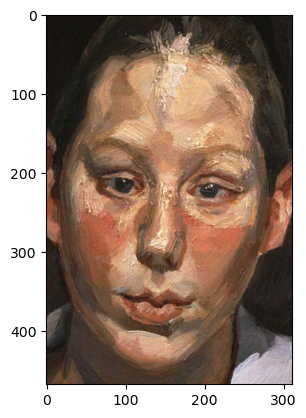

In [19]:
result = session.query(FeatureStore.image_path).filter(FeatureStore.features.l2_distance(embeddings[img_number]) < 19)

In [23]:
for r in result:
    print(r.image_path)

In [43]:
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

my_image_list = []

for r in result:
    file = Image.open(r.image_path) # BGR
    # convert BGR to RGB
    # rgb_image = cv.cvtColor(file, cv.COLOR_BGR2RGB)
    my_image_list.append(file)

# display all images
plt.figure(figsize=(20,10))

columns = 10

for i, image in enumerate(my_image_list):
    plt.subplot(int(len(my_image_list) / columns) + 1, columns, i + 1)
    plt.imshow(image)

array([1.86487925e+00, 1.54612851e+00, 1.15184021e+00, 1.38553047e+00,
       4.87993628e-01, 1.14757431e+00, 2.73608148e-01, 1.16346562e+00,
       4.49416399e-01, 1.46260321e+00, 8.18213344e-01, 4.91228560e-03,
       1.21325076e+00, 1.83600020e+00, 1.48133802e+00, 8.74359429e-01,
       3.37479949e-01, 8.54809403e-01, 1.67098069e+00, 6.75357759e-01,
       7.38966703e-01, 8.66170824e-01, 3.59128743e-01, 1.29308128e+00,
       1.43862450e+00, 1.42526388e-01, 1.50566269e-02, 5.20657487e-02,
       2.81670308e+00, 2.66002917e+00, 1.08631933e+00, 7.57405329e+00,
       6.03353918e-01, 3.34916294e-01, 2.90397912e-01, 4.13884372e-01,
       1.40009153e+00, 6.92386568e-01, 9.58116710e-01, 3.40460598e-01,
       9.42061603e-01, 4.92360920e-01, 1.43095648e+00, 2.11584783e+00,
       2.39710045e+00, 6.22263074e-01, 6.03471518e-01, 1.21212888e+00,
       3.22620440e+00, 9.15457755e-02, 1.23562586e+00, 4.37160879e-01,
       2.45289588e+00, 1.45532227e+00, 5.62390447e-01, 1.54860520e+00,
      

In [44]:
subdir = os.listdir('/home/jaimec/Documents/Torch/learn_pytorch/images/arte')
print(subdir)

In [45]:
for sub in subdir:
    print(sub)

StatementError: (builtins.ValueError) expected ndim to be 1
[SQL: SELECT images_features.image_feature AS images_features_image_feature 
FROM images_features 
WHERE (images_features.image_feature <-> %(image_feature_1)s) < %(param_1)s]
[parameters: [{}]]

In [41]:
root = '/home/jaimec/Documents/Torch/learn_pytorch/images/arte'

StatementError: (builtins.ValueError) expected ndim to be 1
[SQL: SELECT images_features.image_feature AS images_features_image_feature 
FROM images_features 
WHERE (images_features.image_feature <-> %(image_feature_1)s) < %(param_1)s]
[parameters: [{}]]

In [ ]:
subdir = os.listdir(root)
arch_dict = {}
for sub in subdir:
    dir = f"{root}/{sub}/{sub}"
    arch_dict[dir] = os.listdir(os.path.join(root, f"{sub}/{sub}"))

images = []
fpaths = []
for k in arch_dict.keys():
    for f in arch_dict[k]:
        images.append(os.path.join(k, f))
        fpaths.append(k)

# if self.transform is not None:
#     images = [self.transform(img) for img in images]
# return super(MyImageFolder, self).__getitem__(index), self.imgs[index]



In [ ]:
images